# Churn Prediction Project - Week 2: EDA & Baseline Model

## 1. Project Setup

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


## 2. Load Dataset

In [2]:

# Load Telco Customer Churn dataset 
df = pd.read_csv("../Data/Customer Churn Project Data.csv")
df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,$29.85,$29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,$56.95,"$1,889.50",No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,$53.85,$108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),$42.30,"$1,840.75",No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,$70.70,$151.65,Yes


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            7043 non-null   object
 1   SeniorCitizen     7043 non-null   int64 
 2   Partner           7043 non-null   object
 3   Dependents        7043 non-null   object
 4   tenure            7043 non-null   int64 
 5   PhoneService      7043 non-null   object
 6   MultipleLines     7043 non-null   object
 7   InternetService   7043 non-null   object
 8   OnlineSecurity    7043 non-null   object
 9   OnlineBackup      7043 non-null   object
 10  DeviceProtection  7043 non-null   object
 11  TechSupport       7043 non-null   object
 12  StreamingTV       7043 non-null   object
 13  StreamingMovies   7043 non-null   object
 14  Contract          7043 non-null   object
 15  PaperlessBilling  7043 non-null   object
 16  PaymentMethod     7043 non-null   object
 17   MonthlyCharge

In [38]:
# Remove leading/trailing spaces from all column names
df.columns = df.columns.str.strip()


## 3. Explore Data (EDA)

In [39]:
print(df.columns)


Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [40]:

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("dtypes:\n", df.dtypes)

print("\nChurn unique:", df["Churn"].unique()[:10])
print("Churn value counts:\n", df["Churn"].value_counts(dropna=False))

print("\nContract unique:", df["Contract"].unique()[:10])
print("Contract value counts:\n", df["Contract"].value_counts(dropna=False))

print("\nNaNs in key cols:\n", df[["Churn","Contract","MonthlyCharges","TotalCharges","tenure"]].isna().sum())

# Strip column names (you already did this)
df.columns = df.columns.str.strip()

# Only coerce numeric columns; DO NOT apply regex to 'Churn' or 'Contract'
for col in ["MonthlyCharges", "TotalCharges", "tenure"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Fix label whitespace
for col in ["Churn", "Contract", "Partner", "Dependents"]:
    df[col] = df[col].astype(str).str.strip()

# Keep only valid churn labels
df = df[df["Churn"].isin(["Yes", "No"])]

# Handle missing numerics safely (don’t drop whole dataset)
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())
df["MonthlyCharges"] = df["MonthlyCharges"].fillna(df["MonthlyCharges"].median())
df["tenure"] = df["tenure"].fillna(0).astype(int)



Shape: (7043, 20)
Columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
dtypes:
 gender              object
SeniorCitizen        int64
Partner             object
Dependents          object
tenure               int64
PhoneService        object
MultipleLines       object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
Contract            object
PaperlessBilling    object
PaymentMethod       object
MonthlyCharges      object
TotalCharges        object
Churn               object
dtype: object

Churn unique: ['No' 'Yes']
Churn value counts:
 Churn
No     5174
Yes    1869
Name: count, dtype: i

/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


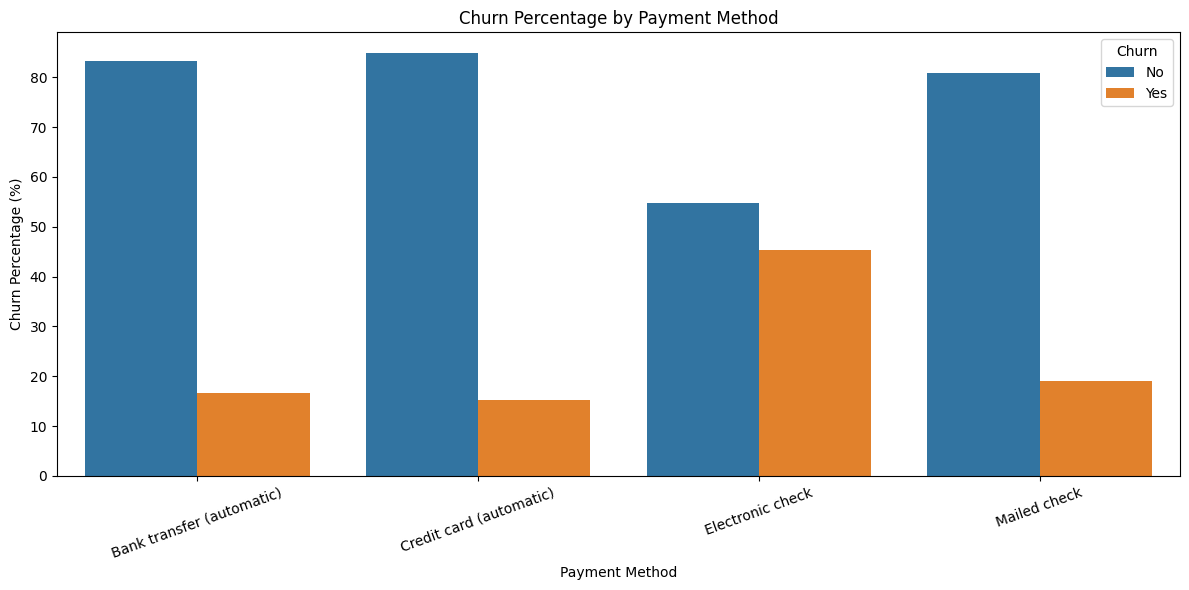

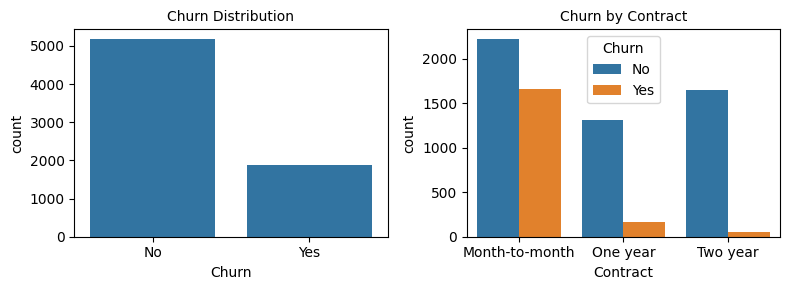

In [41]:
# Percentage churn by payment method
payment_churn = (
    df.groupby("PaymentMethod")["Churn"]
      .value_counts(normalize=True)
      .mul(100)
      .rename("percentage")
      .reset_index()
)

plt.figure(figsize=(12,6))
sns.barplot(data=payment_churn, x="PaymentMethod", y="percentage", hue="Churn")
plt.title("Churn Percentage by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Churn Percentage (%)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(8,3))  # 2 plots side by side

sns.countplot(data=df, x="Churn", ax=axes[0])
axes[0].set_title("Churn Distribution", fontsize=10)

sns.countplot(data=df, x="Contract", hue="Churn", ax=axes[1])
axes[1].set_title("Churn by Contract", fontsize=10)

plt.tight_layout()
plt.show()


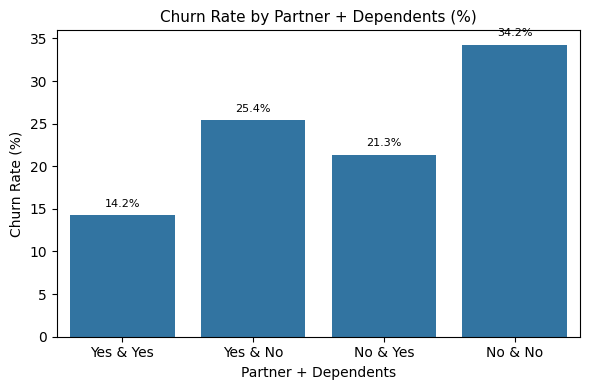

In [42]:

# Partner + Dependet Churn rates

# Create a combined category
df["Partner_Dependents"] = df["Partner"].astype(str).str.strip() + " & " + df["Dependents"].astype(str).str.strip()

# Compute churn rate for each combination
combo_churn = (
    df.groupby("Partner_Dependents")["Churn"]
    .value_counts(normalize=True)
    .rename("ChurnRatePct")
    .mul(100)
    .reset_index()
)

# Filter only "Yes" churn percentage
combo_churn = combo_churn[combo_churn["Churn"] == "Yes"]

# --- Plot it ---
plt.figure(figsize=(6,4))
sns.barplot(data=combo_churn, x="Partner_Dependents", y="ChurnRatePct", order=["Yes & Yes", "Yes & No", "No & Yes", "No & No"])
plt.title("Churn Rate by Partner + Dependents (%)", fontsize=11)
plt.ylabel("Churn Rate (%)")
plt.xlabel("Partner + Dependents")

# Add value labels
for i, v in enumerate(combo_churn.set_index("Partner_Dependents").loc[["Yes & Yes", "Yes & No", "No & Yes", "No & No"]]["ChurnRatePct"]):
    plt.text(i, v + 1, f"{v:.1f}%", ha="center", fontsize=8)

plt.tight_layout()
plt.show()


## 4. Data Preprocessing

In [43]:
import pandas as pd

# HARD RESET: reload from CSV 
df = pd.read_csv("../Data/Customer Churn Project Data.csv")

# Work on a copy
raw = pd.read_csv("../Data/Customer Churn Project Data.csv")
df = raw.copy()

# 2) CLEAN COLUMN NAMES & TEXT LABELS 
df.columns = df.columns.str.strip()

text_cols = [
    "Churn","Partner","Dependents","Contract","PaymentMethod","gender",
    "InternetService","PhoneService","MultipleLines","OnlineSecurity",
    "OnlineBackup","DeviceProtection","TechSupport","StreamingTV",
    "StreamingMovies","PaperlessBilling"
]
for c in text_cols:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

# Keep only valid churn labels
df = df[df["Churn"].isin(["Yes","No"])]

# 3) NUMERIC COLUMNS (ONLY the numeric ones) 
num_cols = [c for c in ["MonthlyCharges","TotalCharges","tenure","SeniorCitizen"] if c in df.columns]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Fill numeric NaNs safely (do NOT drop everything)
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

# 4) TARGET + FEATURES 
df["ChurnFlag"] = (df["Churn"] == "Yes").astype(int)

# DO NOT include target in X; encode categoricals
X = pd.get_dummies(df.drop(columns=["Churn","ChurnFlag"]), drop_first=True)
y = df["ChurnFlag"]

print("\nX shape:", X.shape, " y shape:", y.shape)
print("y distribution:\n", y.value_counts(normalize=True).round(3))

# 5) SPLIT
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, " Test:", X_test.shape)



X shape: (7043, 30)  y shape: (7043,)
y distribution:
 ChurnFlag
0    0.735
1    0.265
Name: proportion, dtype: float64
Train: (5634, 30)  Test: (1409, 30)


/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


## 5. Baseline Logistic Regression Model

In [44]:
# Keep a clean copy of df
df_encoded = df.copy()

# Make sure ChurnFlag is numeric
df_encoded["ChurnFlag"] = df_encoded["ChurnFlag"].astype(int)

# One-hot encode only categorical columns (exclude ChurnFlag)
categorical_cols = df_encoded.select_dtypes(include="object").columns.tolist()
categorical_cols = [col for col in categorical_cols if col != "ChurnFlag"]

df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)

# Features/Target
X = df_encoded.drop("ChurnFlag", axis=1)
y = df_encoded["ChurnFlag"]

print("X shape:", X.shape, " y shape:", y.shape)
print("y balance:\n", y.value_counts(normalize=True))


X shape: (7043, 31)  y shape: (7043,)
y balance:
 ChurnFlag
0    0.73463
1    0.26537
Name: proportion, dtype: float64


In [45]:
import numpy as np
from sklearn.impute import SimpleImputer


print("Before imputation:", X.shape)
imputer = SimpleImputer(strategy='median')
X_imputed_array = imputer.fit_transform(X)

print("After imputation array:", X_imputed_array.shape)

# Identify columns with all NaNs (they caused the mismatch)
null_cols = X.columns[X.isna().all()]
print("Columns dropped because all values were NaN:", list(null_cols))


Before imputation: (7043, 31)
After imputation array: (7043, 29)
Columns dropped because all values were NaN: ['MonthlyCharges', 'TotalCharges']


/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: ['MonthlyCharges' 'TotalCharges']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [46]:
X = X.drop(columns=null_cols)
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)


In [47]:
print("After imputation:", X_imputed.shape)


After imputation: (7043, 29)


In [48]:
# Drop columns that are entirely NaN
X = X.dropna(axis=1, how='all')

# Convert bools → ints
X = X.astype({col: int for col in X.select_dtypes('bool').columns})

# Median impute
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)


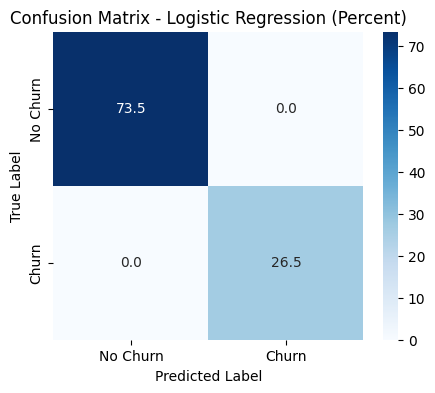

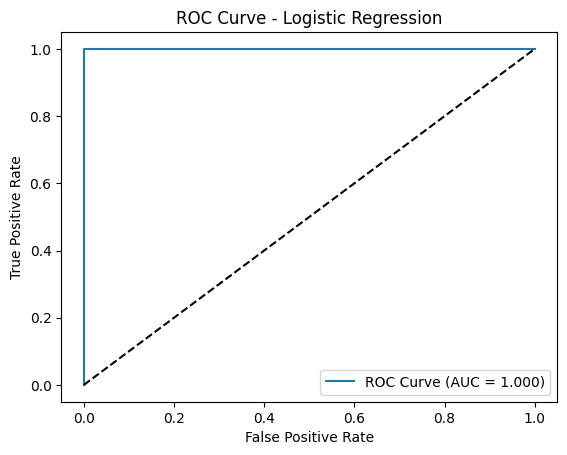

In [49]:
# BASELINE LOGISTIC REGRESSION MODEL

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum() * 100  # Convert to percentage of total

plt.figure(figsize=(5, 4))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])

plt.title("Confusion Matrix - Logistic Regression (Percent)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


## 6. Next Steps
- Try more advanced models: Random Forest, XGBoost.
- Handle class imbalance with SMOTE or class weights.
- Perform hyperparameter tuning (GridSearchCV).
- Evaluate feature importance for interpretability.

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'C': 0.001, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC-AUC: 1.0


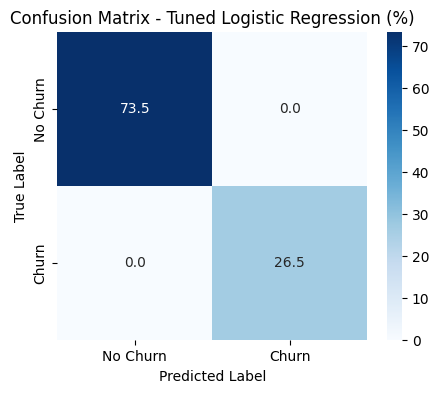

In [50]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],          
    'penalty': ['l1', 'l2'],                      
    'solver': ['liblinear', 'saga'],              
    'class_weight': [None, 'balanced']            
}

# Initialize base model
log_reg = LogisticRegression(max_iter=1000)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='roc_auc',     
    cv=5,                  
    n_jobs=-1,             
    verbose=1
)

# Fit GridSearch to your scaled training data
grid_search.fit(X_train_scaled, y_train)

# Best parameters & best score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

# Evaluate the tuned model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Plot confusion matrix (as %)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum() * 100

plt.figure(figsize=(5,4))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix - Tuned Logistic Regression (%)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [51]:
# Check if any column is highly correlated with ChurnFlag
corrs = X.join(y).corr()['ChurnFlag'].sort_values(ascending=False)
print(corrs.head(15))


Churn_Yes                         1.000000
ChurnFlag                         1.000000
InternetService_Fiber optic       0.308020
PaymentMethod_Electronic check    0.301919
PaperlessBilling_Yes              0.191825
SeniorCitizen                     0.150889
StreamingTV_Yes                   0.063228
StreamingMovies_Yes               0.061382
MultipleLines_Yes                 0.040102
PhoneService_Yes                  0.011942
gender_Male                      -0.008612
MultipleLines_No phone service   -0.011942
DeviceProtection_Yes             -0.066160
OnlineBackup_Yes                 -0.082255
PaymentMethod_Mailed check       -0.091683
Name: ChurnFlag, dtype: float64


In [52]:
leak_cols = corrs[abs(corrs) > 0.95].index.tolist()
X = X.drop(columns=leak_cols, errors='ignore')
print("Dropped leaked columns:", leak_cols)


Dropped leaked columns: ['Churn_Yes', 'ChurnFlag']


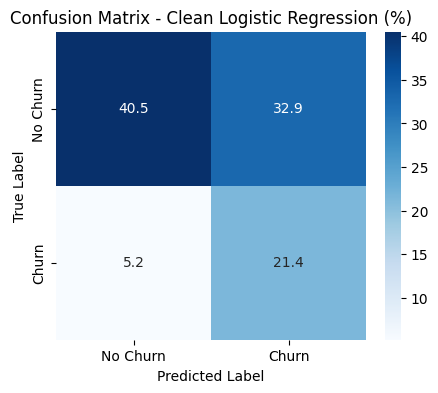

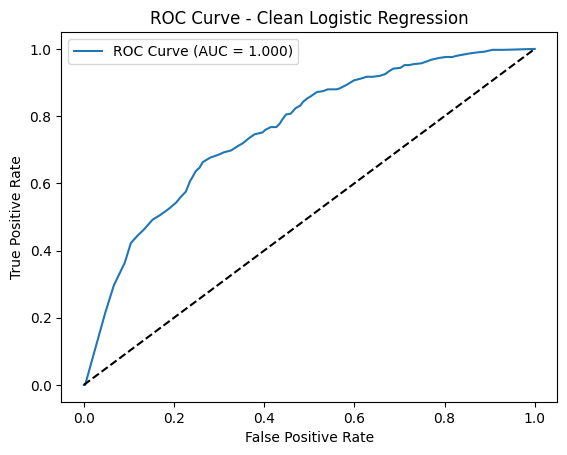

In [53]:
# Recreate train/test split after leakage fix
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Retrain tuned logistic regression (or use GridSearch again)
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear', penalty='l1', C=0.001)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Confusion Matrix (percent)
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum() * 100

plt.figure(figsize=(5,4))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix - Clean Logistic Regression (%)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Clean Logistic Regression")
plt.legend()
plt.show()


In [54]:
# Minimal, leakage-free table for modeling
keep_cols = [
    "Churn", "gender", "SeniorCitizen", "Partner", "Dependents", "tenure",
    "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
    "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod",
    "MonthlyCharges", "TotalCharges"
]
df_model = df[keep_cols].copy()

# Target as 0/1
df_model["ChurnFlag"] = (df_model["Churn"] == "Yes").astype(int)
df_model = df_model.drop(columns=["Churn"])

# Save clean dataset
df_model.to_csv("telco_clean.csv", index=False)
print("Saved: telco_clean.csv", df_model.shape)


Saved: telco_clean.csv (7043, 20)
